In [1]:
# my modules imports
from model import SEIR

    # utils
from utils import init_date, delta_time
from utils import draw_input_params, nb_inputs
from utils import extract_int_value, get_max_load_intensive_care
from utils import idx_to_keys, key_to_idx, input_params, ykeys, box_colors, plotting_names
from utils import Monte_Carlo_sampling, lhs

    # plotting
from utils_plotting import plot_morris, plot_sobol, plot_sobol_time

# other imports
from pprint import pprint
import numpy as np
from scipy.integrate import RK45, odeint
import matplotlib.pyplot as plt

# bokeh plotting
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import row, column
from bokeh.models import PrintfTickFormatter
from bokeh.models import CustomJS, DateRangeSlider
from bokeh.models import Legend, ColumnDataSource, Label, LabelSet, Range1d
from bokeh.palettes import magma, viridis
output_notebook(hide_banner=True)

from ipywidgets import interact, IntSlider, Dropdown, FloatSlider


In [2]:
debug = False
seed = 1111

In [3]:
if(debug):
    x = draw_input_params(seed)
    model = SEIR(x)
    model.prettyprint()
    model.step(dt = 1.0) # dt in days 
    model.prettyprint()

In [4]:
# function used to quikcly get integer results from input_params
def f(input_params, step_in_day = 1.0, tend = 300.0, verbose = False):
    model = SEIR(input_params)
    
    if(verbose):
        model.prettyprint()
        
    fcn = model.get_fcn()
    y_ini = model.get_state()

    # in number of days
    tini = input_params[key_to_idx['t0']]
    tend = tini+tend # in days
    number_of_steps = int((tend-tini)/step_in_day)
    
    t_simu = np.linspace(tini,tend,number_of_steps)
    
    rtol, atol = 1e-3, 1e-6 # default values
    solution = odeint(func = fcn, t = t_simu, y0 = y_ini) 
    
    sol, period = extract_int_value(solution, step_in_day)

    return sol,  period

## Q1)

In [5]:
def plot_solution(seed = None, verbose = False):
    x = draw_input_params(seed)
    tini = x[key_to_idx['t0']]
    tend = 200.0
    
    sol, period = f(x, tend = tend)

    times = [init_date+delta_time*tini+k*period*delta_time for k in range(int(tend))]
    
    max_time, max_U = get_max_load_intensive_care(sol, period)
    
    print('Max intensive care load at days {} with {} patients.'.format(max_time, max_U))
    
    fig_sol = figure(plot_height=450, plot_width=900, title="Solution", x_axis_type='datetime')
    
    legend_it = []
    for idx, (key, name) in enumerate(plotting_names.items()):
        c = fig_sol.x(times, sol[:,idx], line_width=1, color = box_colors[key], alpha=0.9, muted_color=box_colors[key], muted_alpha=0.01) # legend_label="Speed")
        legend_it.append((name, [c]))
        
    legend = Legend(items=legend_it)
    legend.click_policy="mute"
    fig_sol.add_layout(legend, 'right')

    show(fig_sol, notebook_handle=True)
    

In [6]:
plot_solution(seed = seed)

Max intensive care load at days 83 with 219369 patients.


In [174]:
def Monte_Carlo_Umax(N = 100):
    list_U = []
    list_times = []
    
    for k in range(N): 
        x = draw_input_params()
        model = SEIR(x)

        fcn = model.get_fcn()
        y_ini = model.get_state()
        
        step_in_day = 0.1 # 0.1 : 10 points per day
        tini = 0.
        tend = 200.0
        number_of_steps = int((tend-tini)/step_in_day)

        t = np.linspace(tini,tend,number_of_steps)

        rtol, atol = 1e-3, 1e-6 # default values
        
        solution = odeint(func = fcn, t = t, y0 = y_ini)
    
        sol, period = extract_int_value(solution, step_in_day)
        max_time, max_U = get_max_load_intensive_care(sol, period)
        list_U.append(max_U)
        list_times.append(max_time)
    
    return np.array(list_U), np.array(list_times)

In [175]:
N=100
list_U, list_times = Monte_Carlo_Umax(N=N)

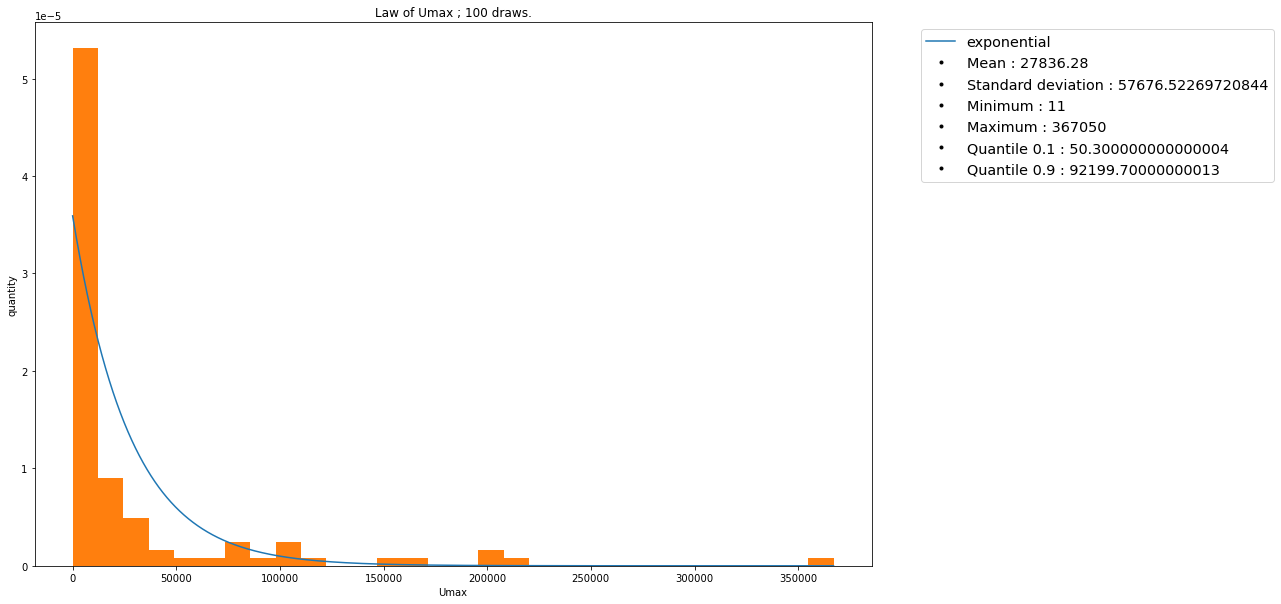

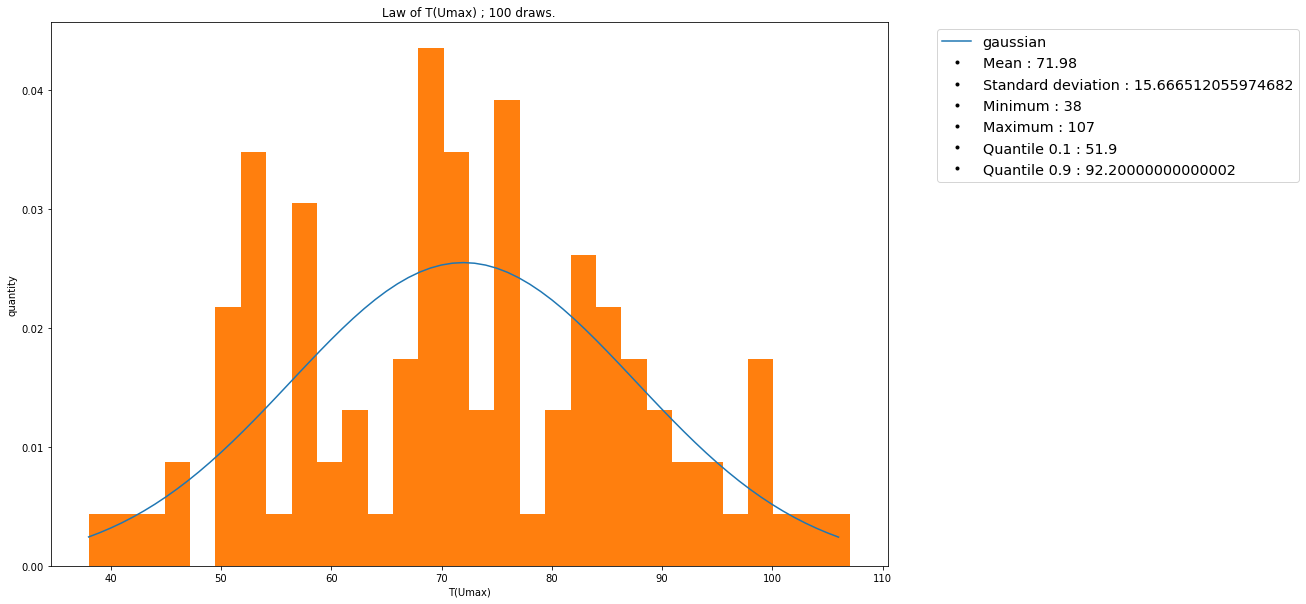

In [17]:
from scipy.stats import chi2, norm, poisson, expon
bins = 30

def get_law(array, bins, name, law = None, name_law = '', savefig = None):
    mean, std = np.mean(array), np.std(array)
    m, M = np.min(array), np.max(array)
    q10, q90 = np.quantile(array, q=0.1),np.quantile(array, q=0.9)
    
    dico = {
        'Mean' : mean,
        'Standard deviation' : std,
        'Minimum' : m,
        'Maximum' : M,
        'Quantile 0.1':q10,
        'Quantile 0.9':q90
    }
    
    N = array.shape[0]
    
    fig, ax = plt.subplots(figsize = (15,10))

    if(law!=None):
        x = np.arange(m, M)
        y = law(x, mean, std) # scale = 1/lambda = Esp(U)
        ax.plot(x,y, label = name_law)
        
    ax.hist(array, bins = bins , density = True)
    
    ax.set_title('Law of {} ; {} draws.'.format(name, N), fontsize=12)
    ax.set_xlabel(name, fontsize=10)
    ax.set_ylabel('quantity', fontsize=10)
    
    for key, value in dico.items():
        ax.plot([],[], '.', label = '{} : {}'.format(key, value), color = 'k')
        
    plt.legend(loc='upper left', fontsize='x-large', title_fontsize='x-small', ncol=1, bbox_to_anchor=(1.05, 1))

    if(savefig!=None):
        plt.savefig(savefig+'.png', dpi = 40)
    else:
        plt.show()

gaussian_pdf = lambda x, mean, std : norm.pdf(x=x, loc = mean, scale = std)
exponential_pdf = lambda x, mean, std : expon.pdf(x=x, loc=0, scale=mean) # scale = 1/lambda = Esp(U)
chi2_k1_pdf = lambda x, mean, std : chi2.pdf(x=x, df=1, loc=0, scale=mean) # df : degrees of freedom 
poisson_pmf = lambda x, mean, std : poisson.pmf(x, mu = mean, loc=0)

get_law(list_U, bins = bins, name = 'Umax', law = exponential_pdf, name_law = 'exponential', savefig = 'law_Umax')
get_law(list_times, bins = bins, name = 'T(Umax)', law = gaussian_pdf, name_law = 'gaussian', savefig = 'law_T(Umax)')

## Q3) Méthode de Morris

**TODO** :
* vérifier que le $\delta$ tel qu'il est créé ici ne pose pas de problème (le fait qu'il soit proportionnel à la longueur de l'intervalle qu'on regarde). Regarder également quelle valeur de $\delta$ sont priviligiées en général.

    # naive way
    mu = []
    mu_abs = []
    sigma = []
    for idx in range(nb_inputs):
        mu_i = 0
        mu_abs_i = 0 
        for r in range(R):
            mu_i += fd[r,idx]
            mu_abs_i += np.abs(fd[r,idx])
        mu.append(mu_i/R)
        mu_abs.append(mu_abs_i/R)
    
    for idx in range(nb_inputs):
        sigma_i = 0
        for r in range(R): 
            sigma_i += (fd[r,idx]-mu[idx])**2
        sigma.append(sigma_i/(R-1))

In [10]:
def compute_finite_diff(samples, delta, fn, h):
    from utils import vectorize
    delta_vect = vectorize(delta) # delta*np.identity(nb_inputs) #
    pprint(delta_vect)
    arr = np.zeros((len(samples), nb_inputs, h))
    df_x = [fn(*(f(sample))) for sample in samples]
    for r, sample in enumerate(samples): # loop of size R
        for idx, d in enumerate(delta_vect): # d = [0,...,0, delta_idx, 0, ..., 0], d_idx = delta_idx
            p = input_params[idx_to_keys[idx]]
            xdx = sample+d 
            while(xdx[idx]<p[0] or xdx[idx]>p[1]):
                d = 0.5*d
                xdx = sample+d
            df = (fn(*f(xdx))-df_x[idx])/d[idx]
            arr[r, idx] = df
    return arr

def Morris(fn, h, R = 100, delta = 1e-3, method = 'lhs'):
    if(method == 'lhs'):
        samples = lhs(R=R)
    elif(method == 'MC'):
        samples = Monte_Carlo_sampling(R=R)
    else:
        print("Method {} not recognized. \nChoices : 'lhs', 'MC'".format(method))
        return
    
    fd = compute_finite_diff(samples, delta, fn, h)
    # we want : [number of outputs considered x nb_of_params x samples_number]
    # for now it's all inverted ...
    fd = np.transpose(fd) #  np.moveaxis(fd, [2, 0], [0, 3])
    mu_arr = np.mean(np.abs(fd), axis = -1) # np.array([np.mean(np.abs(fd[:,k,:]), axis = -1) for k in range(nb_inputs)])
    mean = np.mean(fd, axis = -1)
    sigma_arr = np.std(fd, axis = -1)
    # could return a dictionnary too...
    return mu_arr, sigma_arr  # np.array(mu_abs), np.array(sigma)

In [ ]:
get_U = lambda arr, period : get_max_load_intensive_care(arr, period)[1]
mu_arr, sigma_arr = Morris(fn = get_max_load_intensive_care, h = 2, R = 20, delta = 1e-6, method = 'lhs')
# pa,NI,R0,μ,N,t0,I0−

In [12]:
print(mu_arr)

[[3.79230769e+07 2.22000000e+08 9.38000000e+08 3.45000000e+08
  1.55000000e+08 1.30500000e+08 2.99500000e+06 1.43750000e+06
  1.56333333e+06 8.30158730e+06 5.05555556e+08 9.62650602e+05
  1.46774194e+06 9.15841584e+05 6.24545455e+10]
 [1.59226128e+10 6.33022987e+10 3.19241300e+11 2.84056143e+11
  5.26776525e+10 2.63128794e+10 7.91441667e+08 5.88483991e+08
  5.27707518e+08 2.51305970e+09 1.75417782e+11 1.90737665e+08
  5.45903963e+08 1.56747603e+08 1.45245792e+13]]


In [13]:
print('Umax : ')
plot_morris(mu_arr[1], sigma_arr[1], names = 'default')

Umax : 


In [14]:
print('T(Umax) : ')
plot_morris(mu_arr[0], sigma_arr[0], names = 'default')


T(Umax) : 


In [13]:
test_MC = True
if(test_MC):
    mu_arr_MC, sigma_arr_MC = Morris(fn = get_max_load_intensive_care, h = 2, R = 100, delta = 1e-8, method = 'MC')

In [14]:
if(test_MC):
    print('T(Umax) : ')
    plot_morris(mu_arr_MC[:,0], sigma_arr_MC[:,0], names = 'default')
    print('Umax : ')
    plot_morris(mu_arr_MC[:,1], sigma_arr_MC[:,1], names = 'default')

T(Umax) : 


Umax : 


## Q4) Analyse de sensiblité de Sobol

In [38]:
# indexes that we are interested into
names = ['pa','NI','R0','mu','t0','Im0']
idxes = [key_to_idx[n] for n in names]

In [39]:
def Sobol(fn, R = 100, method = 'lhs'):
    if(method == 'lhs'):
        A,B = lhs(R=R), lhs(R=R) # not how we are suppose to do it I think.
    elif(method == 'MC'):
        A,B = Monte_Carlo_sampling(R=R),Monte_Carlo_sampling(R=R)
    else:
        print("Method {} not recognized. \nChoices : 'lhs', 'MC'".format(method))
        return
    
    fA = np.array([fn(*f(X)) for X in A])
    fB = np.array([fn(*f(X)) for X in B])

    s = list(fA.shape)
    s[0] = nb_inputs
    S = np.zeros(s) 
    St = np.zeros(s)

    mu_tot = np.mean(fA, axis = 0) 
    sigma_tot = np.var(fA, axis = 0)
    
    for i in range(nb_inputs):
        Ci = np.copy(A)
        Ci[:,i] = B[:,i]
        fCi = np.array([fn(*f(X)) for X in Ci])
        
        Vhat_i = np.mean(fB*(fCi-fA), axis = 0) 
        Vhat_mi = np.mean(fA*(fA-fCi), axis = 0)
        
        S[i] = Vhat_i/sigma_tot
        St[i] = Vhat_mi/sigma_tot
        
    return S, St

In [40]:
S, St = Sobol(fn = get_max_load_intensive_care, R = 3200, method = 'lhs')

In [31]:
plot_sobol(S[idxes,0],St[idxes,0], names = names)

In [42]:
plot_sobol(S[:,0],St[:,0])

In [43]:
plot_sobol(S[:,1],St[:,1])

In [19]:
plot_sobol(S[idxes,1],St[idxes,1], names = names)

In [20]:
def HUDRH(sol, period):
    # order : S, Im, Ip, Rm, RI, H, U, RH, D, DR
    return np.transpose(sol[1:, [ykeys['H'],ykeys['U'],ykeys['D'],ykeys['RH']]])

S, St = Sobol(fn = HUDRH, R = 200, method = 'MC')

In [21]:
for idx, s in enumerate(['H','U','D','RH']):  
    print('{:-^100}'.format(' '+s+' '))
    plot_sobol_time(S[idxes,idx,:],St[idxes,idx,:], names = names)

------------------------------------------------ H -------------------------------------------------


------------------------------------------------ U -------------------------------------------------


------------------------------------------------ D -------------------------------------------------


------------------------------------------------ RH ------------------------------------------------


## Q6)

In [7]:
import pandas as pd
import numpy as np
from pprint import pprint
from datetime import timedelta, date, datetime

In [8]:
path = 'data/data.csv'
path_dr = 'data/data_DR.csv'

delta_time = timedelta(days = 1)
start = datetime(year = 2020, month = 2, day = 21)
first_lockdown = datetime(year = 2020, month = 3, day = 18)
end_value =  datetime(year = 2020, month = 5, day = 11) # end lockdown
list_of_times = [start+k*delta_time for k in range((end_value-start+delta_time).days)]

type(start)

datetime.datetime

In [9]:
len(list_of_times)

81

In [10]:
def convert_data(path, path_dr, end_date = '2020-05-11', end_date_DR = '11/05'):
    # all
    df = pd.read_csv(path, sep = ';', header=0, parse_dates = ['jour'])
    df = df.groupby(by = ['jour']).sum()
    result = np.where(df.index==end_date)[0]
    assert(len(result)==1)
    df=df[:result[0]+1]
    
    # DR
    df_dr = pd.read_csv(path_dr, sep = ',', header=0)
    result = df_dr[df_dr['date']==end_date_DR].index.values[0]
    df_dr=df_dr[:result+1]
    dr = df_dr['nbre'].values
    dr[1:] -= dr[:-1]
    
    nb_to_add = len(dr) - len(df)
    a = np.empty((nb_to_add))
    a[:] = np.nan
    H = np.concatenate([a, df['hosp'].values])
    U = np.concatenate([a, df['rea'].values])
    D = np.concatenate([a, df['dc'].values])
    R = np.concatenate([a, df['rad'].values])

    mon_dico = {
        'date' : list_of_times,
        'H' : H,
        'U' : U,
        'RH' : R,
        'D' : D,
        'DR' : dr
    }
    
    return pd.DataFrame.from_dict(mon_dico)

In [11]:
values = convert_data(path, path_dr)
values

,date,H,U,RH,D,DR
0,2020-02-21,NaN,NaN,NaN,NaN,12
1,2020-02-22,NaN,NaN,NaN,NaN,0
2,2020-02-23,NaN,NaN,NaN,NaN,0
3,2020-02-24,NaN,NaN,NaN,NaN,0
4,2020-02-25,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...
76,2020-05-07,46184.0,5817.0,109784.0,32683.0,629
77,2020-05-08,45220.0,5633.0,111288.0,32904.0,642
78,2020-05-09,45001.0,5521.0,111799.0,33056.0,433
79,2020-05-10,44906.0,5450.0,112186.0,33192.0,209


In [12]:
def plot_data(values, pred = None):
    p = figure(plot_height=450, plot_width=900, x_axis_type='datetime')
    p.x(values['date'], values['H'], color=box_colors['H'], alpha=1, legend_label = 'H',  muted_color=box_colors['H'], muted_alpha=0.01)
    p.x(values['date'], values['U'], color=box_colors['U'], alpha=1, legend_label = 'U', muted_color=box_colors['U'], muted_alpha=0.01)
    p.x(values['date'], values['D'], color=box_colors['D'], alpha=1, legend_label = 'D', muted_color=box_colors['D'], muted_alpha=0.01)
    p.x(values['date'], values['RH'], color=box_colors['RH'], alpha=1, legend_label = 'RH', muted_color=box_colors['RH'], muted_alpha=0.01)
    p.x(values['date'], values['DR'], color=box_colors['DR'], alpha=1, legend_label = 'DR', muted_color=box_colors['DR'], muted_alpha=0.01)
        
    if(pred != None):
        p.line(pred['date'], pred['H'], line_width=1,color=box_colors['H'], alpha=1)
        p.line(pred['date'], pred['U'], line_width=1,color=box_colors['U'], alpha=1)
        p.line(pred['date'], pred['D'], line_width=1,color=box_colors['D'], alpha=1)
        p.line(pred['date'], pred['RH'], line_width=1,color=box_colors['RH'], alpha=1)
        p.line(pred['date'], pred['DR'], line_width=1,color=box_colors['DR'], alpha=1)
        
    p.legend.location = "top_left"
    p.legend.click_policy = "mute"
    
    show(p)

In [13]:
plot_data(values)

# Q7)

In [14]:
from scipy.optimize import minimize
from datetime import datetime

min_start = init_date
end_simulation = datetime(year = 2020, month = 3, day = 31) # 31/03
dt_day_max = (end_simulation-min_start).days

In [26]:
def fun(x, target, dt = 1.0, t_end = end_simulation, select = ['H','U','RH','D','DR'], verbose = False):
    t_ini = min_start+x[key_to_idx['t0']]*delta_time
    span_simu = (end_simulation-t_ini).days
    if(verbose):
        print('Init date : {} - simulation spanning {} days'.format(t_ini, span_simu))
        
    sol, period = f(x, step_in_day = dt, tend = span_simu)
    idxes = [ykeys[n] for n in select]
    sol = sol[:,idxes] # all times but only select indexes
    
    a = np.zeros((dt_day_max-span_simu, len(select)))

    pred = np.concatenate([a,sol])
 
    return least_squared(pred, target)

def least_squared(pred, target):
    eps = 1e-8
    residuals = ((pred-target)/np.sqrt(pred+eps))**2
    return np.sum(np.where(residuals == residuals, residuals, 0))

In [27]:
x0 = draw_input_params()  # draw_input_params()
target = values.values[:dt_day_max,1:] # not taking datetime
bounds = input_params.values()
print(target.shape)

(66, 5)


In [28]:
argmin = minimize(fun, x0, args=(target), bounds=bounds)
print(argmin)

ValueError: negative dimensions are not allowed

In [22]:
launches = 200
err_min = np.inf
x_best = None
for k in range(launches):
    x0 = draw_input_params()
    argmin = minimize(fun, x0, args=(target), bounds=bounds, tol = 1e-8)
    err = argmin.fun
    if(err < err_min):
        x_best = argmin.x
        err_min = err

print(err_min)

KeyboardInterrupt: 

In [ ]:
t_ini = min_start+x_best[key_to_idx['t0']]*delta_time
span_simu = (end_value-t_ini).days
sol, period = f(x_best, step_in_day = 1, tend = span_simu)
pred_dict = {
    'date': [t_ini+k*delta_time for k in range(span_simu)],
    'H' : sol[:,ykeys['H']],
    'U' : sol[:,ykeys['U']],
    'RH' : sol[:,ykeys['RH']],
    'D' : sol[:,ykeys['D']],
    'DR' : sol[:,ykeys['DR']]
}

In [ ]:
plot_data(values, pred_dict)